Student: TRINH Quoc Anh

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('tr_eikon_eod_data.csv', sep=',')
df.head()

,Date,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
1,2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2,2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
3,2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
4,2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82


In [3]:
symbol = "AAPL.O"
data = df[["Date", symbol]].dropna()
data.head()

,Date,AAPL.O
1,2010-01-04,30.572827
2,2010-01-05,30.625684
3,2010-01-06,30.138541
4,2010-01-07,30.082827
5,2010-01-08,30.282827


In [4]:
short_term_window = 40
long_term_window = 190
data["Date"] =  pd.to_datetime(data["Date"], format="%Y-%m-%d")
data["SMA_CT"] = data[symbol].rolling(short_term_window).mean()
data["SMA_LT"] = data[symbol].rolling(long_term_window).mean()
data["Return"] = np.log(data[symbol]) - np.log(data[symbol].shift(1))
data["Position"] = np.sign(data["SMA_CT"] - data["SMA_LT"])
data["Strategy"] = data["Return"] * data["Position"]
# data = data.dropna()
# data["Cumsum_return"] = data["Return"].cumsum()
# data["Cumsum_strategy"] = data["Strategy"].cumsum()
data.head()

,Date,AAPL.O,SMA_CT,SMA_LT,Return,Position,Strategy
1,2010-01-04,30.572827,NaN,NaN,NaN,NaN,NaN
2,2010-01-05,30.625684,NaN,NaN,0.001727,NaN,NaN
3,2010-01-06,30.138541,NaN,NaN,-0.016034,NaN,NaN
4,2010-01-07,30.082827,NaN,NaN,-0.001850,NaN,NaN
5,2010-01-08,30.282827,NaN,NaN,0.006626,NaN,NaN


In [5]:
# Building the LSTM model

# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle



Using TensorFlow backend.


In [6]:
data_model = data[["Return"]].dropna() # TODO: turn the data to dataframe
# data_1_period = data_model[:1000]
data_1_period = data_model[-2000:]
data_1_period.head()

,Return
144,0.018642
145,0.003530
146,-0.002542
147,0.018344
148,-0.011885


In [7]:
# Get the raw data values from the pandas data frame.
data_raw = data_1_period.values.astype("float32")
dataset = data_raw
# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
# scaler = MinMaxScaler(feature_range = (0, 1))
# dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[ 0.01864202],
       [ 0.00353011],
       [-0.00254228],
       [ 0.01834353],
       [-0.01188495]], dtype=float32)

In [8]:
len(dataset)

2000

In [9]:
# Train test split
TRAIN_SIZE = 0.75

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (1500, 500)


In [10]:
train

array([[ 0.01864202],
       [ 0.00353011],
       [-0.00254228],
       ...,
       [ 0.00302888],
       [-0.00943008],
       [ 0.00566871]], dtype=float32)

In [11]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))


In [12]:
# Create test and training sets for one-step-ahead regression.
window_size = 20
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)


Original training data shape:
(1479, 20)
New training data shape:
(1479, 1, 20)


In [13]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    model.add(LSTM(32, input_shape = (1, window_size)))    
#     model.add(LSTM(32,return_sequences=True, input_shape = (1, window_size)))
#     model.add(Dropout(0.5))
#     model.add(LSTM(16))
#     model.add(Dropout(0.5))
#     model.add(LSTM(32))
#     model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "RMSProp")
    model.fit(train_X, 
              train_Y, 
              epochs = 5, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/5
 - 2s - loss: 3.0030e-04
Epoch 2/5
 - 1s - loss: 2.8997e-04
Epoch 3/5
 - 1s - loss: 2.8361e-04
Epoch 4/5
 - 1s - loss: 2.8614e-04
Epoch 5/5
 - 1s - loss: 2.8100e-04


In [14]:
def predict_and_score(model, X, Y):
#     pred = scaler.inverse_transform(model.predict(X))
#     orig_data = scaler.inverse_transform([Y])
    pred = model.predict(X)
    orig_data = [Y]
#     print(len(model.predict(X)))
#     print(pred)
#     print(len(pred))
#     print(len([Y]))
#     print(orig_data)
#     print(len(orig_data))
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 0.02 RMSE
Test data score: 0.01 RMSE


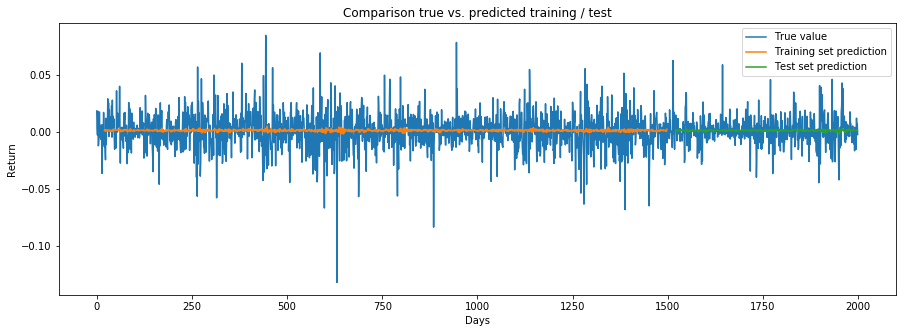

In [15]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(dataset, label = "True value")
# plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Return")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

In [16]:
data_final = data[-len(test_predict):]
data_final["Predicted_return"] = test_predict
data_final["Position_LSTM"] = np.sign(data_final["Predicted_return"])
data_final["Strategy_LSTM"] = data_final["Return"] * data_final["Position_LSTM"]
data_final["Cumsum_return"] = data_final["Return"].cumsum()
data_final["Cumsum_return_naive"] = data_final["Strategy"].cumsum()
data_final["Cumsum_strategy_LSTM"] = data_final["Strategy_LSTM"].cumsum()
data_final.head(100)

/home/tqa/anaconda3/envs/projet_S5/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/tqa/anaconda3/envs/projet_S5/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tqa/anaconda3/envs/projet_S5/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,Date,AAPL.O,SMA_CT,SMA_LT,Return,Position,Strategy,Predicted_return,Position_LSTM,Strategy_LSTM,Cumsum_return,Cumsum_return_naive,Cumsum_strategy_LSTM
1720,2016-08-05,107.48,98.40350,102.731184,0.015093,-1.0,-0.015093,0.001476,1.0,0.015093,0.015093,-0.015093,0.015093
1721,2016-08-08,108.37,98.64200,102.659447,0.008247,-1.0,-0.008247,0.002091,1.0,0.008247,0.023339,-0.023339,0.023339
1722,2016-08-09,108.81,98.92875,102.595711,0.004052,-1.0,-0.004052,0.000371,1.0,0.004052,0.027391,-0.027391,0.027391
1723,2016-08-10,108.00,99.19225,102.526974,-0.007472,-1.0,0.007472,0.002081,1.0,-0.007472,0.019919,-0.019919,0.019919
1724,2016-08-11,107.93,99.46200,102.460447,-0.000648,-1.0,0.000648,0.002222,1.0,-0.000648,0.019271,-0.019271,0.019271
1725,2016-08-12,108.18,99.72775,102.415237,0.002314,-1.0,-0.002314,0.000717,1.0,0.002314,0.021585,-0.021585,0.021585
1726,2016-08-15,109.48,100.08150,102.380342,0.011945,-1.0,-0.011945,0.001343,1.0,0.011945,0.033530,-0.033530,0.033530
1727,2016-08-16,109.38,100.43850,102.346974,-0.000914,-1.0,0.000914,0.001869,1.0,-0.000914,0.032616,-0.032616,0.032616
1728,2016-08-17,109.22,100.77125,102.330553,-0.001464,-1.0,0.001464,0.001768,1.0,-0.001464,0.031152,-0.031152,0.031152
1729,2016-08-18,109.08,101.10950,102.303737,-0.001283,-1.0,0.001283,0.001248,1.0,-0.001283,0.029870,-0.029870,0.029870


In [17]:
data_final.tail(100)

,Date,AAPL.O,SMA_CT,SMA_LT,Return,Position,Strategy,Predicted_return,Position_LSTM,Strategy_LSTM,Cumsum_return,Cumsum_return_naive,Cumsum_strategy_LSTM
2113,2018-02-07,159.54,172.02725,160.416263,-0.021640,1.0,-0.021640,0.001818,1.0,-0.021640,0.410083,0.360822,0.410083
2114,2018-02-08,155.15,171.58925,160.422368,-0.027902,1.0,-0.027902,0.001331,1.0,-0.027902,0.382180,0.332920,0.382180
2115,2018-02-09,156.41,171.20700,160.438947,0.008088,1.0,0.008088,0.001102,1.0,0.008088,0.390269,0.341008,0.390269
2116,2018-02-12,162.71,170.96800,160.485053,0.039489,1.0,0.039489,0.001973,1.0,0.039489,0.429758,0.380497,0.429758
2117,2018-02-13,164.34,170.77100,160.528421,0.009968,1.0,0.009968,0.001861,1.0,0.009968,0.439726,0.390465,0.439726
2118,2018-02-14,167.37,170.60600,160.589842,0.018269,1.0,0.018269,0.000671,1.0,0.018269,0.457995,0.408734,0.457995
2119,2018-02-15,172.99,170.52025,160.682053,0.033027,1.0,0.033027,0.002543,1.0,0.033027,0.491022,0.441761,0.491022
2120,2018-02-16,172.43,170.46750,160.798789,-0.003242,1.0,-0.003242,0.002175,1.0,-0.003242,0.487779,0.438519,0.487779
2122,2018-02-20,171.85,170.40500,160.900421,-0.003369,1.0,-0.003369,0.000266,1.0,-0.003369,0.484410,0.435149,0.484410
2123,2018-02-21,171.07,170.30650,160.995211,-0.004549,1.0,-0.004549,0.001948,1.0,-0.004549,0.479861,0.430600,0.479861


The real return is 0.56, the returns of LSTM is 0.52. We can see that this LSTM model do not outperform the market yet. However, this LSTM model is still naive and there's much room for improvement. For example:
1. Divide the dataset into periods and train a model for each periods
2. Use a better strategy to decide long/short position
3. Tune LSTM model
4. Try another formula of return